In [1]:
import matplotlib.pyplot as pl
import torch
import numpy as np
from matplotlib.lines import Line2D
import ot.plot

In [2]:
import sys
sys.path.append('../../code/')
from utils import def_colormap 
from traj import traj_balanced,traj_UOT_KL,traj_UOT_MMD,traj_UOT_KKL,dist_traj,sampling,subsampling

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"
print(device)
torch.set_default_dtype(torch.float64)

cpu


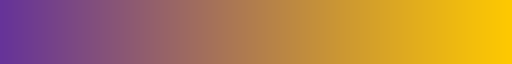

In [4]:
cmp=def_colormap()
cmp

In [5]:
lam=[1e-1,5e-1,1e0,5e0,1e1,5e1]
eps=[1e-1,5e-1,1e0]
sigma=[.1,.5,1,5]#,1e1]
method=["balanced sink","balanced linear","uot kl sink","uot kl convex","uot kkl","uot mmd"]

#T = 80 # number of timepoints T=3,5,7,8,9,10,20,30,40,50,60,70,80
T_l=[3,5,7,8,9,10,20,30,40,50,60,70,80]
N = 20 # number of particles per timepoint
n = 20 #nb of seed
t_final=1

n_seed=10
numiter=100
result=torch.zeros((n_seed,len(method),len(lam)))

In [ ]:
for t in T_l:
    for s in range(n_seed):
        print(str(s) + " : ", end="")
        X_true=sampling(t,N,n,seed=s,shift=5,scale=.1,tau=30)
        X_sub=subsampling(X_true,N,n,s)
        for i,m in enumerate(method):
            print(i,end=" ")
            for j,l in enumerate(lam):
                if m=="uot mmd":
                    #res2=torch.zeros(len(sigma))
                    #for p,sig in enumerate(sigma):
                    #    Y_MMD=traj_UOT_MMD(X_sub,lam=l,sigma=sig,regul=1e1)
                    #    res2[p]=dist_traj(X_true,Y_MMD)
                    #result[s,i,j]=torch.min(res2)
                    result[s,i,j]=0              
                else:
                    res=torch.zeros(len(eps))
                    for k,e in enumerate(eps):
                        if m=="balanced sink":
                            Ye_bal,_=traj_balanced(X_sub,eps=e,numiter=numiter)
                            res[k]=dist_traj(X_true,Ye_bal)
                        elif m=="balanced linear":
                            _,Y_bal=traj_balanced(X_sub)
                            res[k]=dist_traj(X_true,Y_bal)
                        elif m=="uot kl sink":
                            Ye_KL,_=traj_UOT_KL(X_sub,lam=l,eps=e,numiter=numiter)
                            res[k]=dist_traj(X_true,Ye_KL)
                        elif m=="uot kl convex":
                            _,Y_KL=traj_UOT_KL(X_sub,lam=l,eps=e,numiter=numiter)
                            res[k]=dist_traj(X_true,Y_KL)
                        elif m=="uot kkl":
                            res2=torch.zeros(len(sigma))
                            for p,sig in enumerate(sigma):
                                #print(sig)
                                Y_KKL=traj_UOT_KKL(X_sub,lam=l,eps=e,sigma=sig,numiter=numiter)
                                if torch.any(Y_KKL.isnan()):
                                    res2[p]=float('inf')
                                else:
                                    res2[p]=dist_traj(X_true,Y_KKL)
                            res[k]=torch.min(res2)
                        elif m=="MMD":
                            res2=torch.zeros(len(sigma))
                            for p,sig in enumerate(sigma):
                                #print(sig)
                                Y_MMD=traj_UOT_MMD(X_sub,lam=l,eps=e,sigma=sig,numiter=numiter)
                                if torch.any(Y_MMD.isnan()):
                                    res2[p]=float('inf')
                                else:
                                    res2[p]=dist_traj(X_true,Y_MMD)
                            res[k]=torch.min(res2)
                            
                    result[s,i,j]=torch.min(res)
        print()
        #np.savetxt("result/trajectory/Traj_T"+str(t)+"_n"+str(n)+"_N"+str(N)+".txt",result.reshape((n_seed,-1)))

In [7]:
result.shape

torch.Size([10, 6, 6])

In [6]:
n=20#10
N=20#10

In [7]:
result_mean=np.zeros((len(method),len(T_l)))
result_std=np.zeros((len(method),len(T_l)))
for i,t in enumerate(T_l):
    res=np.loadtxt("result/trajectory/Traj_T"+str(t)+"_n"+str(n)+"_N"+str(N)+".txt").reshape(n_seed,len(method),len(lam))
    res=np.min(res,-1)/t
    result_mean[:,i]=np.mean(res,0)
    result_std[:,i]=np.std(res,0)
    
result_mean=result_mean[:-1,:]
result_std=result_std[:-1,:]/2

In [8]:
label1 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{OT}^\epsilon})", color='C0', linestyle='-',linewidth=8)
label2 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{OT}})/\min$", color='C1', linestyle='-',linewidth=8)
label3 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KL}})$", color='C2', linestyle='-',linewidth=8)
label4 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KL}^\epsilon})$", color='C3', linestyle='-',linewidth=8)
label5 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KKL}^\epsilon})$", color='C4', linestyle='-',linewidth=8)
label6 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{MMD}})$", color='C5', linestyle='-',linewidth=8)

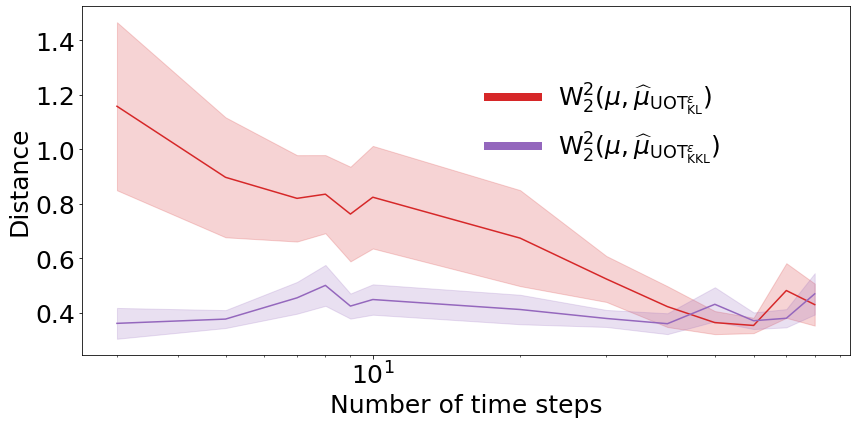

In [10]:
pl.figure(figsize=(12,6))
ax=pl.subplot(1,1,1)
for i in range(len(method)-1):
    if i==3 or i==4:
        pl.plot(T_l,result_mean[i,:],c="C%i"%i)
        pl.fill_between(T_l, result_mean[i,:] -  result_std[i,:], result_mean[i,:] + result_std[i,:], alpha=0.2,color="C%i"%i)


handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label4,label5])#,label3,label4,label5])#,label6])   
pl.xlabel('Number of time steps',fontsize=25)
pl.ylabel('Distance',fontsize=25)
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
#pl.yscale("log")
pl.xscale("log")
pl.tight_layout()
pl.legend(frameon=False,bbox_to_anchor=(.5,.85),handles=handles, prop={'size': 25})
pl.savefig("../../Figures/UOT/traj_comparison_loss_kl_kkl.pdf",bbox_inches='tight')

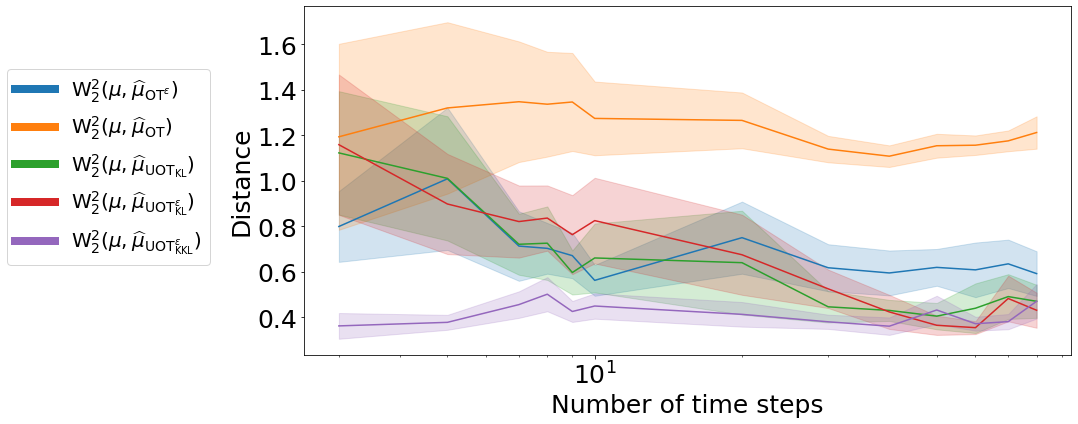

In [12]:
pl.figure(figsize=(12,6))
for i in range(len(method)-1):
    pl.plot(T_l,result_mean[i,:],c="C%i"%i)
    pl.fill_between(T_l, result_mean[i,:] -  result_std[i,:], result_mean[i,:] + result_std[i,:], alpha=0.2,color="C%i"%i)


label1 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{OT}^\epsilon})$", color='C0', linestyle='-',linewidth=8)
label2 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{OT}})$", color='C1', linestyle='-',linewidth=8)
label3 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KL}})$", color='C2', linestyle='-',linewidth=8)
label4 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KL}^\epsilon})$", color='C3', linestyle='-',linewidth=8)
label5 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KKL}^\epsilon})$", color='C4', linestyle='-',linewidth=8)
label6 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{MMD}})$", color='C5', linestyle='-',linewidth=8)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2,label3,label4,label5])#,label6])   
pl.xlabel('Number of time steps',fontsize=25)
pl.ylabel('Distance',fontsize=25)
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
#pl.yscale("log")
pl.xscale("log")
pl.tight_layout()
pl.legend(bbox_to_anchor=(-.11,.85),handles=handles, prop={'size': 20})
pl.savefig("../../Figures/UOT/traj_comparison_loss.pdf",bbox_inches='tight')

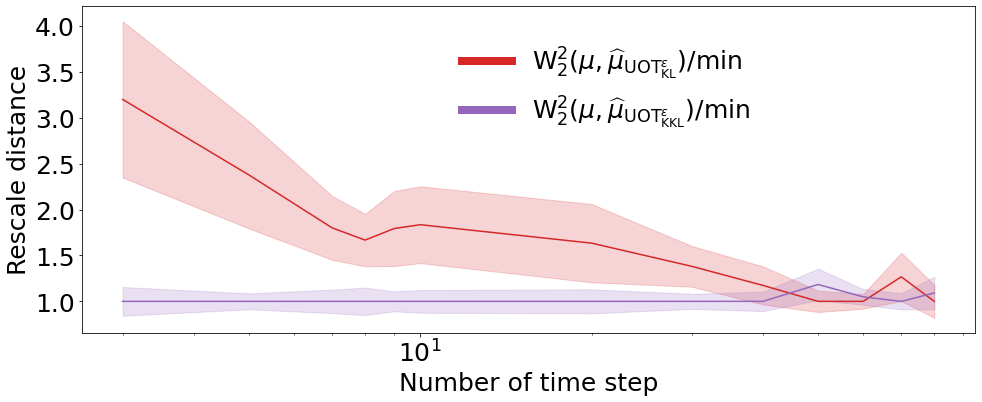

In [18]:
res_min=np.min(result_mean[3:5,:],0)
result_norm=result_mean/res_min
result_std_norm=result_std/(res_min)
pl.figure(figsize=(16,6))
#ax=pl.subplot(1,1,1)
for i in range(len(method)-1):
    if i==3 or i==4:
        pl.plot(T_l,result_norm[i,:],c="C%i"%i)
        pl.fill_between(T_l, result_norm[i,:] -  result_std_norm[i,:], result_norm[i,:] + result_std_norm[i,:], alpha=0.2,color="C%i"%i)


label1 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{OT}^\epsilon})/\min$", color='C0', linestyle='-',linewidth=8)
label2 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{OT}})/\min$", color='C1', linestyle='-',linewidth=8)
label3 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KL}})/\min$", color='C2', linestyle='-',linewidth=8)
label4 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KL}^\epsilon})/\min$", color='C3', linestyle='-',linewidth=8)
label5 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KKL}^\epsilon})/\min$", color='C4', linestyle='-',linewidth=8)
label6 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{MMD}})/\min$", color='C5', linestyle='-',linewidth=8)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label4,label5])#,label3,label4,label5,label6])   
pl.xlabel('Number of time step',fontsize=25)
pl.ylabel('Rescale distance',fontsize=25)
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
pl.xscale('log')
#ax.set_xticks(lam)
#ax.set_xticklabels(lam)
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
pl.legend(frameon=False,bbox_to_anchor=(0.4,.95),handles=handles, prop={'size': 25})
pl.savefig("../../Figures/UOT/traj_comparison_loss_norm_kl_kkl.pdf",bbox_inches='tight')

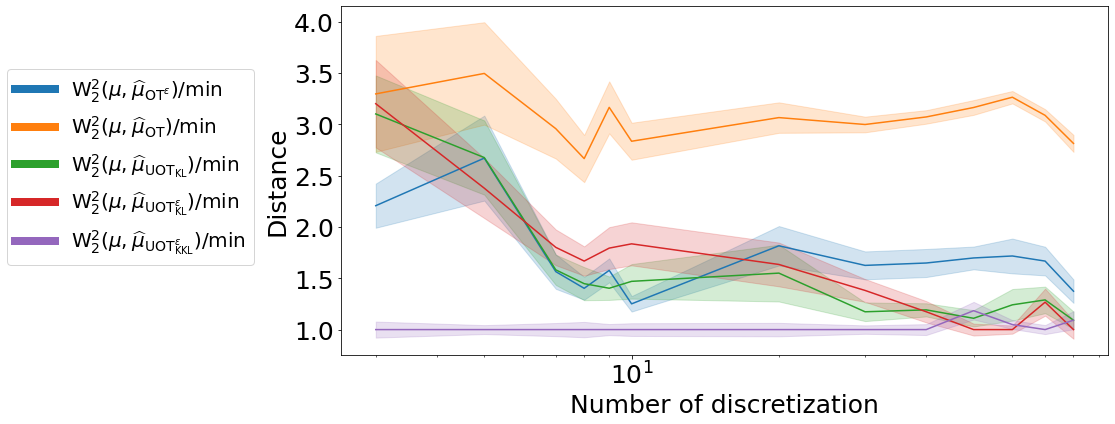

In [22]:
res_min=np.min(result_mean,0)
result_norm=result_mean/res_min
result_std_norm=result_std/(2*res_min)
pl.figure(figsize=(12,6))
for i in range(len(method)-1):
    pl.plot(T_l,result_norm[i,:],c="C%i"%i)
    pl.fill_between(T_l, result_norm[i,:] -  result_std_norm[i,:], result_norm[i,:] + result_std_norm[i,:], alpha=0.2,color="C%i"%i)


label1 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{OT}^\epsilon})/\min$", color='C0', linestyle='-',linewidth=8)
label2 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{OT}})/\min$", color='C1', linestyle='-',linewidth=8)
label3 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KL}})/\min$", color='C2', linestyle='-',linewidth=8)
label4 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KL}^\epsilon})/\min$", color='C3', linestyle='-',linewidth=8)
label5 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{KKL}^\epsilon})/\min$", color='C4', linestyle='-',linewidth=8)
label6 = Line2D([0], [0], label="$\mathrm{W}_2^2(\mu,\widehat{\mu}_{\mathrm{UOT}_\mathrm{MMD}})/\min$", color='C5', linestyle='-',linewidth=8)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2,label3,label4,label5])#,label6])   
pl.xlabel('Number of discretization',fontsize=25)
pl.ylabel('Distance',fontsize=25)
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
#pl.yscale("log")
pl.xscale("log")
pl.tight_layout()
pl.legend(bbox_to_anchor=(-0.1,.85),handles=handles, prop={'size': 20})
pl.savefig("../../Figures/UOT/traj_comparison_loss_norm.pdf",bbox_inches='tight')

In [91]:

#result_mean=np.loadtxt("result/trajectory/Traj_T"+str(T)+"_n"+str(n)+"_N"+str(N)+".txt")

In [25]:
result_mean.shape

(6, 13)

In [16]:
np.min(res,1).shape

(5, 6)

In [19]:
result_l[0]

array([2.54076293, 3.54638707, 3.09639123, 2.71034763, 2.18948246,
       1.98628345])

# Figure

In [289]:
T = 200 # number of timepoints
N = 50 # number of particles per timepoint
n = 1 #nb of seed
t_final=1

X_true=sampling(T,N,n,seed=1,shift=5,scale=.1,tau=30)

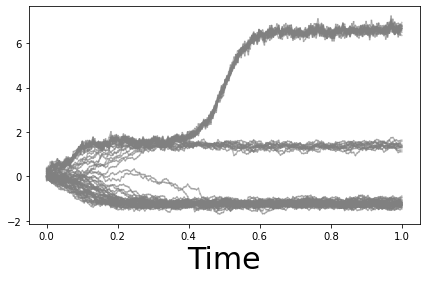

In [291]:
fig=pl.figure(figsize=(7,4))
cmap = pl.get_cmap('BuGn')
#im=pl.scatter(X_true[:,:,0],X_true[:,:,1],c=np.kron(np.arange(T),np.ones(N*n+int(N*n/3))),s=10,cmap=cmp,vmin=0,vmax=T*t_final)
for i in range(T-1):
    ot.plot.plot2D_samples_mat(X_true[i,:,[0,1]], X_true[i+1,:,[0,1]], np.eye(n*N+int(N*n/3)), c="grey",alpha=.5)
pl.xlabel("Time",size=30)
#pl.ylabel("Space",size=30)
pl.savefig("../../Figures/UOT/traj_sampled_ground_truth.pdf",bbox_inches='tight')

In [292]:
T = 15 # number of timepoints
N = 5 # number of particles per timepoint
n = 2 #nb of seed
t_final=1

X_true=sampling(T,N,n,seed=1,shift=5,scale=.1,tau=30)

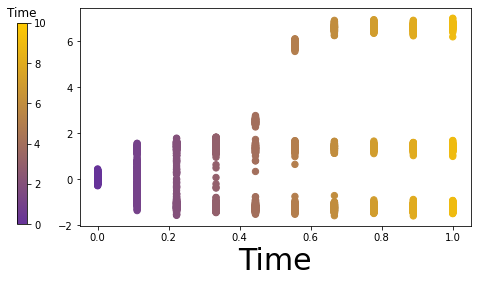

In [305]:
fig=pl.figure(figsize=(7,4))
cmap = pl.get_cmap('BuGn')
im=pl.scatter(X_true[:,:,0],X_true[:,:,1],c=np.kron(np.arange(T),np.ones(N*n+int(N*n/3))),s=40,cmap=cmp,vmin=0,vmax=T*t_final)
#for i in range(T-1):
#    ot.plot.plot2D_samples_mat(X_true[i,:,[0,1]], X_true[i+1,:,[0,1]], np.eye(n*N+int(N*n/3)), c="grey",alpha=.5)
pl.xlabel("Time",size=30)
#pl.ylabel("$x_0$",size=30)
cbar_ax = fig.add_axes([0, 0.13, 0.02, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_alpha(1)
cb.draw_all()
cbar_ax.set_title("Time")
pl.savefig("../../Figures/UOT/traj_disrectization.pdf",bbox_inches='tight')

# Oneshot

In [306]:
T = 10 # number of timepoints
N = 20 # number of particles per timepoint
n = 10 #nb of seed
t_final=1

X_true=sampling(T,N,n,seed=0,shift=5,scale=.1,tau=30)

Text(0.5, 1.0, 'Time')

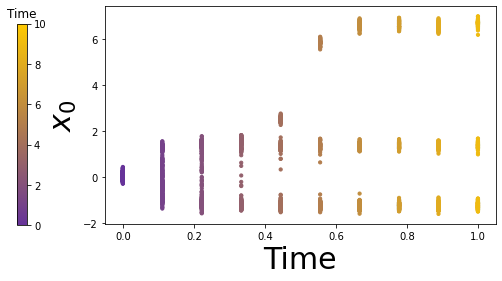

In [307]:
fig=pl.figure(figsize=(7,4))
cmap = pl.get_cmap('BuGn')
im=pl.scatter(X_true[:,:,0],X_true[:,:,1],c=np.kron(np.arange(T),np.ones(N*n+int(N*n/3))),s=10,cmap=cmp,vmin=0,vmax=T*t_final)
#for i in range(T-1):
#    ot.plot.plot2D_samples_mat(X_true[i,:,[0,1]], X_true[i+1,:,[0,1]], np.eye(n*N+int(N*n/3)), c="grey",alpha=.5)
pl.xlabel("Time",size=30)
pl.ylabel("$x_0$",size=30)
cbar_ax = fig.add_axes([-0.05, 0.12, 0.02, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_alpha(1)
cb.draw_all()
cbar_ax.set_title("Time")
#pl.savefig("result/trajectory/ground_truth.pdf",bbox_inches='tight')

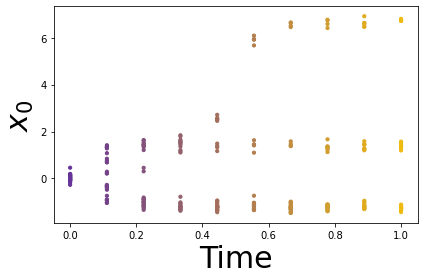

In [308]:
X_sub=subsampling(X_true,N,n,0)
N_sub=X_sub.shape[1]
pl.figure(figsize=(6,4))
pl.scatter(X_sub[:,:,0],X_sub[:,:,1],c=np.kron(np.arange(T),np.ones(N_sub)),s=10,cmap=cmp,vmin=0,vmax=T*t_final)
pl.xlabel("Time",size=30)
pl.ylabel("$x_0$",size=30)
pl.tight_layout()
#pl.savefig("result/trajectory/sub_sampling.pdf",bbox_inches='tight')

8.934945479761629 10.666108223134113


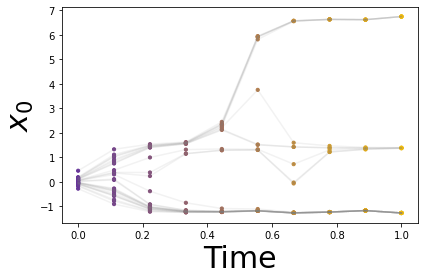

In [309]:
Y_bal,Ye_bal=traj_balanced(X_sub,eps=1e-1,numiter=100)
print(dist_traj(X_true,Y_bal),dist_traj(X_true,Ye_bal))

pl.figure(figsize=(6,4))
pl.scatter(Y_bal[:,:,0],Y_bal[:,:,1],c=np.kron(np.arange(T),np.ones(N_sub)),s=10,cmap=cmp,vmin=0,vmax=T*t_final)
pl.xlabel("Time",size=30)
pl.ylabel("$x_0$",size=30)
for i in range(T-1):
    ot.plot.plot2D_samples_mat(Y_bal[i,:,[0,1]], Y_bal[i+1,:,[0,1]], np.eye(N_sub), c="grey",alpha=.1)
pl.tight_layout()
#pl.savefig("result/trajectory/banlanced.pdf",bbox_inches='tight')

29.218942519954144 28.084075803684538


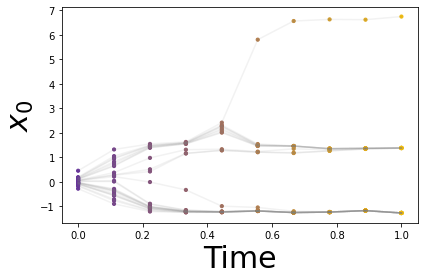

In [310]:
Y_KL,Ye_KL=traj_UOT_KL(X_sub,lam=5,eps=1e-1,numiter=100)
print(dist_traj(X_true,Y_KL),dist_traj(X_true,Ye_KL))

pl.figure(figsize=(6,4))
pl.scatter(Y_KL[:,:,0],Y_KL[:,:,1],c=np.kron(np.arange(T),np.ones(N_sub)),s=10,cmap=cmp,vmin=0,vmax=T*t_final)
pl.xlabel("Time",size=30)
pl.ylabel("$x_0$",size=30)
for i in range(T-1):
    ot.plot.plot2D_samples_mat(Y_KL[i,:,[0,1]], Y_KL[i+1,:,[0,1]], np.eye(N_sub), c="grey",alpha=.1)
pl.tight_layout()
#pl.savefig("result/trajectory/banlanced.pdf",bbox_inches='tight')

In [311]:
X_sub.shape

torch.Size([10, 26, 2])

12.084033174669052


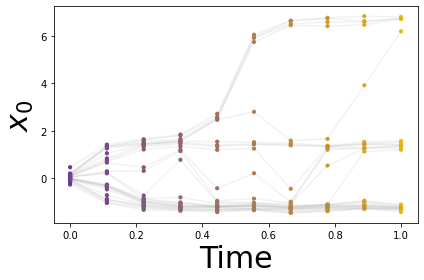

In [312]:
Y_MMD=traj_UOT_MMD(X_sub,lam=5,sigma=1,regul=1e0)
print(dist_traj(X_true,Y_MMD))

pl.figure(figsize=(6,4))
pl.scatter(Y_MMD[:,:,0],Y_MMD[:,:,1],c=np.kron(np.arange(T),np.ones(N_sub)),s=10,cmap=cmp,vmin=0,vmax=T*t_final)
pl.xlabel("Time",size=30)
pl.ylabel("$x_0$",size=30)
for i in range(T-1):
    ot.plot.plot2D_samples_mat(Y_MMD[i,:,[0,1]], Y_MMD[i+1,:,[0,1]], np.eye(N_sub), c="grey",alpha=.1)
pl.tight_layout()
#pl.savefig("result/trajectory/banlanced.pdf",bbox_inches='tight')

14.14913728134083


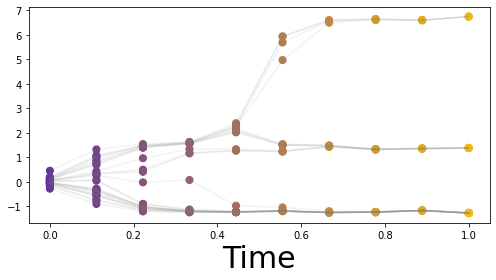

In [314]:
Y_KKL=traj_UOT_KKL(X_sub,lam=3,eps=1e-1,sigma=.1,numiter=100)
print(dist_traj(X_true,Y_KKL))

pl.figure(figsize=(7,4))
pl.scatter(Y_KKL[:,:,0],Y_KKL[:,:,1],c=np.kron(np.arange(T),np.ones(N_sub)),s=50,cmap=cmp,vmin=0,vmax=T*t_final)
pl.xlabel("Time",size=30)
#pl.ylabel("$x_0$",size=30)
for i in range(T-1):
    ot.plot.plot2D_samples_mat(Y_KKL[i,:,[0,1]], Y_KKL[i+1,:,[0,1]], np.eye(N_sub), c="grey",alpha=.1)
pl.tight_layout()
pl.savefig("../../Figures/UOT/traj_KKL.pdf",bbox_inches='tight')

In [ ]:
"""
    #Sinkhorn iterates
    C=torch.tensor(ot.dist(Y3e[i,:,1:],Y3e[i+1,:,1:]))
    _,Ky=kernel(torch.tensor(Y3e[i,:,1:]),torch.tensor(Y3e[i+1,:,1:]),sigma=1,k="gaussian")
    u,v,G=semi_sinkhorn(torch.tensor(w3[i]),torch.tensor(w3[i+1]),C,lam2=lam2,eps=1e-2,numiter=1000,pen="MMD",Ky=Ky,
                   lr=3e-2,numiter2=2)
    P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
    P=P.numpy()
    Y3e[i+1,:,:]=P@Y3e[i+1,:,:]
    print(np.round(P.sum()),end=" ")
"""

In [ ]:
"""
# UOT KL Sinkhorn for weights
Y2=np.array(X, copy=True)
w2=np.ones((X.shape[0],X.shape[1]))
P_l=[]
for i in range(T-1):
    C=torch.tensor(ot.dist(Y2[i,:,1:],Y2[i+1,:,1:]))
    #u,v,G=sinkhorn(torch.tensor(w2[i]),torch.tensor(w2[i+1]),C,lam2=1,eps=1e-1,numiter=300,pen="kl")
    P=UOT_KL(w2[i],w2[i+1],C,lam2=1,solver="CLARABEL")
    #P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
    #P=P.numpy()
    w2[i+1]=np.sum(P,axis=0)
    P_l+=[P]
print(P.sum())
Y2.shape

d=0
pl.figure(figsize=(12,5))
for i in range(T):
    pl.scatter(Y2[i,:,0],Y2[i,:,d+1],color=color[i],s=10*w2[i])
for i in range(T-1):
    ot.plot.plot2D_samples_mat(Y2[i,:,[0,d+1]].T, Y2[i+1,:,[0,d+1]].T, P_l[i], c="grey",alpha=.1)
#pl.plot(np.linspace(0, t_final, paths_gt.shape[1]), paths_gt[:, :, d].T, color = 'green', alpha = 0.1);
"""

In [ ]:
"""# UOT MMD Sinkhorn for weights
Y3=np.array(X, copy=True)
w3=np.ones((X.shape[0],X.shape[1]))
P_l=[]
for i in range(T-1):
    C=torch.tensor(ot.dist(Y3[i,:,1:],Y3[i+1,:,1:]))
    Kx,Ky=kernel(torch.tensor(Y3[i,:,1:]),torch.tensor(Y3[i+1,:,1:]),sigma=1,k="gaussian")
    #Kx=torch.tensor(Kx).float(),torch.tensor(Ky).float()
    u,v,G=sinkhorn(torch.tensor(w3[i]),torch.tensor(w3[i+1]),C,lam2=.5,eps=1e-1,numiter=300,pen="MMD",Kx=Kx,Ky=Ky)
    P=u.reshape((-1, 1)) * G * v.reshape((1, -1))
    P=P.numpy()
    w3[i+1]=np.sum(P,axis=0)
    P_l+=[P]
    #Y2_res[i+1,:,:]=P@Y2_res[i+1,:,:]
    #print(P.sum())
Y3.shape

d=0
pl.figure(figsize=(12,5))
for i in range(T):
    pl.scatter(Y2[i,:,0],Y2[i,:,d+1],color=color[i],s=10*w3[i])
for i in range(T-1):
    ot.plot.plot2D_samples_mat(Y2[i,:,[0,d+1]].T, Y2[i+1,:,[0,d+1]].T, P_l[i], c="grey",alpha=.1)
#pl.plot(np.linspace(0, t_final, paths_gt.shape[1]), paths_gt[:, :, d].T, color = 'green', alpha = 0.1);
"""